In [1]:
import numpy as np
import os

# 学習済みモデルとtalkenizerのimport
from transformers import BertForSequenceClassification, BertTokenizer
# データセットの作成
from datasets import load_dataset

# finetuning
import peft

# 訓練時のハイパーパラメータと学習の設定
from transformers import Trainer, TrainingArguments

# 評価用の関数の設定
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# 混同行列の作成
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# モデルの保存
import torch

In [3]:
# 訓練済みモデルの読み込み
base_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# ファインチューニングの設定
peft_config = peft.LoraConfig(
    # タスクのタイプ
    task_type=peft.TaskType.SEQ_CLS,
    # 差分行列のランク
    r=100,
    lora_alpha=32,
    lora_dropout=0.1,
    # 推論に使う場合はinference_modeはTrue, 学習の時はFalse
    inference_mode=False,
    # 再学習の使う層
    target_modules="all-linear"
)

In [5]:
# peftをモデルに適用
sc_model = peft.get_peft_model(model=base_model, peft_config=peft_config)
# モデルをcudaに渡す
sc_model.cuda()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): L

In [6]:
# 学習するparamsの数
sc_model.print_trainable_parameters()

trainable params: 16,821,807 || all params: 126,383,454 || trainable%: 13.310133935728643


In [7]:
# tokenizerの読み込み
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [8]:
# csvファイルをデータセットに変換
train_data = load_dataset("csv", data_files="train_data.csv", column_names=["text", "label"], split="train")
valid_data = load_dataset("csv", data_files="valid_data.csv", column_names=["text", "label"], split="train")
test_data = load_dataset("csv", data_files="test_data.csv", column_names=["text", "label"], split="train")

In [9]:
# labelをstringからclasslabelに変更
train_data = train_data.class_encode_column("label")
valid_data = valid_data.class_encode_column("label")
test_data = test_data.class_encode_column("label")

In [10]:
# トークン化の関数
def tokenize(batch):
    # データセットのテキスト列を取得
    texts = batch["text"]
    if isinstance(texts, str):
        # テキストが単一の文字列の場合、tokenizerに直接渡す
        return tokenizer(texts, padding=True, truncation=True, max_length=128)
    elif isinstance(texts, (list, tuple)):
        # テキストがリストまたはタプルの場合、各要素を文字列に変換してtokenizerに渡す
        return tokenizer([str(text) for text in texts], padding=True, truncation=True, max_length=128)
    else:
        # 不正な入力形式の場合はエラーを発生させる
        raise ValueError("Invalid input format. Should be a string, a list/tuple of strings.")

In [11]:
# トークン化の関数を適用
train_data = train_data.map(tokenize, batched=True, batch_size=len(train_data))
valid_data = valid_data.map(tokenize, batched=True, batch_size=len(valid_data))
test_data = test_data.map(tokenize, batched=True, batch_size=len(test_data))

In [12]:
# pytorchに入力できるようにformatを変更
train_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
valid_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_data.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [13]:
# 評価用の関数の設定
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(result):
    labels = result.label_ids
    preds = result.predictions.argmax(-1)
    # accuracy_scoreの算出
    acc = accuracy_score(labels, preds)
    # f1_scoreの算出
    f1 = f1_score(labels, preds, average="weighted")
    return {
        "accuracy score": acc,
        "f1 score": f1
    }

In [16]:
# ハイパーパラメータの設定
training_args = TrainingArguments(
    output_dir="outputs2/results/",
    evaluation_strategy="epoch",
    num_train_epochs=10,
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="outputs2/logs/"
)

In [17]:
# 学習の設定
trainer = Trainer(
    model=sc_model,
    args = training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=valid_data,
    tokenizer=tokenizer
)

In [18]:
# 学習
trainer.train()

  0%|          | 0/10260 [00:00<?, ?it/s]

{'loss': 0.5072, 'grad_norm': 6.099201202392578, 'learning_rate': 0.0001, 'epoch': 0.49}
{'loss': 0.3263, 'grad_norm': 1.7606921195983887, 'learning_rate': 9.487704918032787e-05, 'epoch': 0.97}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.2579139769077301, 'eval_accuracy score': 0.8976608187134503, 'eval_f1 score': 0.8850912612231628, 'eval_runtime': 4.7758, 'eval_samples_per_second': 214.832, 'eval_steps_per_second': 6.91, 'epoch': 1.0}
{'loss': 0.2852, 'grad_norm': 7.84589147567749, 'learning_rate': 8.975409836065574e-05, 'epoch': 1.46}
{'loss': 0.2736, 'grad_norm': 2.150392770767212, 'learning_rate': 8.463114754098362e-05, 'epoch': 1.95}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.25763487815856934, 'eval_accuracy score': 0.898635477582846, 'eval_f1 score': 0.8959919462690046, 'eval_runtime': 4.7957, 'eval_samples_per_second': 213.944, 'eval_steps_per_second': 6.881, 'epoch': 2.0}
{'loss': 0.2148, 'grad_norm': 1.0020976066589355, 'learning_rate': 7.950819672131148e-05, 'epoch': 2.44}
{'loss': 0.2354, 'grad_norm': 4.245909214019775, 'learning_rate': 7.438524590163934e-05, 'epoch': 2.92}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.2530713379383087, 'eval_accuracy score': 0.9152046783625731, 'eval_f1 score': 0.9128067998240824, 'eval_runtime': 4.8097, 'eval_samples_per_second': 213.318, 'eval_steps_per_second': 6.861, 'epoch': 3.0}
{'loss': 0.1955, 'grad_norm': 4.24986457824707, 'learning_rate': 6.926229508196722e-05, 'epoch': 3.41}
{'loss': 0.1855, 'grad_norm': 0.05837570130825043, 'learning_rate': 6.41393442622951e-05, 'epoch': 3.9}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.32365164160728455, 'eval_accuracy score': 0.9122807017543859, 'eval_f1 score': 0.9056611019571428, 'eval_runtime': 4.7715, 'eval_samples_per_second': 215.026, 'eval_steps_per_second': 6.916, 'epoch': 4.0}
{'loss': 0.1681, 'grad_norm': 0.11040841042995453, 'learning_rate': 5.9016393442622956e-05, 'epoch': 4.39}
{'loss': 0.1512, 'grad_norm': 4.504243850708008, 'learning_rate': 5.389344262295082e-05, 'epoch': 4.87}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.36017686128616333, 'eval_accuracy score': 0.905458089668616, 'eval_f1 score': 0.9047538885712264, 'eval_runtime': 4.7805, 'eval_samples_per_second': 214.621, 'eval_steps_per_second': 6.903, 'epoch': 5.0}
{'loss': 0.1291, 'grad_norm': 0.05257025361061096, 'learning_rate': 4.8770491803278687e-05, 'epoch': 5.36}
{'loss': 0.1311, 'grad_norm': 5.614421844482422, 'learning_rate': 4.364754098360656e-05, 'epoch': 5.85}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.4004164934158325, 'eval_accuracy score': 0.9103313840155945, 'eval_f1 score': 0.9024647777916651, 'eval_runtime': 4.7892, 'eval_samples_per_second': 214.231, 'eval_steps_per_second': 6.89, 'epoch': 6.0}
{'loss': 0.0966, 'grad_norm': 1.408848524093628, 'learning_rate': 3.8524590163934424e-05, 'epoch': 6.34}
{'loss': 0.1009, 'grad_norm': 0.062466811388731, 'learning_rate': 3.34016393442623e-05, 'epoch': 6.82}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.42207029461860657, 'eval_accuracy score': 0.9103313840155945, 'eval_f1 score': 0.9067817782563539, 'eval_runtime': 4.776, 'eval_samples_per_second': 214.824, 'eval_steps_per_second': 6.91, 'epoch': 7.0}
{'loss': 0.0791, 'grad_norm': 0.048890121281147, 'learning_rate': 2.8278688524590162e-05, 'epoch': 7.31}
{'loss': 0.0896, 'grad_norm': 0.10301068425178528, 'learning_rate': 2.3155737704918034e-05, 'epoch': 7.8}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.48620253801345825, 'eval_accuracy score': 0.9083820662768031, 'eval_f1 score': 0.9063648551545508, 'eval_runtime': 4.7722, 'eval_samples_per_second': 214.997, 'eval_steps_per_second': 6.915, 'epoch': 8.0}
{'loss': 0.0745, 'grad_norm': 0.13018794357776642, 'learning_rate': 1.8032786885245903e-05, 'epoch': 8.28}
{'loss': 0.0614, 'grad_norm': 6.191988945007324, 'learning_rate': 1.2909836065573772e-05, 'epoch': 8.77}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.5168946981430054, 'eval_accuracy score': 0.9074074074074074, 'eval_f1 score': 0.9042111004759562, 'eval_runtime': 4.784, 'eval_samples_per_second': 214.467, 'eval_steps_per_second': 6.898, 'epoch': 9.0}
{'loss': 0.063, 'grad_norm': 0.08803786337375641, 'learning_rate': 7.78688524590164e-06, 'epoch': 9.26}
{'loss': 0.0476, 'grad_norm': 0.04232846572995186, 'learning_rate': 2.663934426229508e-06, 'epoch': 9.75}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.510105311870575, 'eval_accuracy score': 0.9083820662768031, 'eval_f1 score': 0.9056671384776341, 'eval_runtime': 4.7826, 'eval_samples_per_second': 214.527, 'eval_steps_per_second': 6.9, 'epoch': 10.0}
{'train_runtime': 1020.0083, 'train_samples_per_second': 80.47, 'train_steps_per_second': 10.059, 'train_loss': 0.16809648194043492, 'epoch': 10.0}


TrainOutput(global_step=10260, training_loss=0.16809648194043492, metrics={'train_runtime': 1020.0083, 'train_samples_per_second': 80.47, 'train_steps_per_second': 10.059, 'train_loss': 0.16809648194043492, 'epoch': 10.0})

In [19]:
# モデルの評価
trainer.evaluate()

  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.510105311870575,
 'eval_accuracy score': 0.9083820662768031,
 'eval_f1 score': 0.9056671384776341,
 'eval_runtime': 4.7714,
 'eval_samples_per_second': 215.031,
 'eval_steps_per_second': 6.916,
 'epoch': 10.0}

In [20]:
# テストデータで推論
pred_output = trainer.predict(test_data)
pred_output

  0%|          | 0/33 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[-5.7506027 , -1.7235444 ,  5.2213283 ],
       [-4.9510417 ,  2.734855  ,  0.9241381 ],
       [-0.68046254,  1.2705716 , -0.61047566],
       ...,
       [-6.0539746 , -1.4492317 ,  5.1749377 ],
       [-6.696121  , -2.0811133 ,  6.179077  ],
       [-6.5176153 , -2.2150993 ,  6.1439247 ]], dtype=float32), label_ids=array([2, 2, 2, ..., 2, 2, 2], dtype=int64), metrics={'test_loss': 0.5869067311286926, 'test_accuracy score': 0.8977604673807206, 'test_f1 score': 0.8946062622193269, 'test_runtime': 4.7783, 'test_samples_per_second': 214.93, 'test_steps_per_second': 6.906})

## 混同行列

In [21]:
# pred_outputの中から最も高い確率のものを求めてそれをy_predとする
y_pred = np.argmax(pred_output.predictions, axis=1)
y_pred

array([2, 1, 1, ..., 2, 2, 2], dtype=int64)

In [22]:
# 正解の用意
y_test = np.array(test_data["label"])
# label_nameの取得
label_name = test_data.features["label"].names

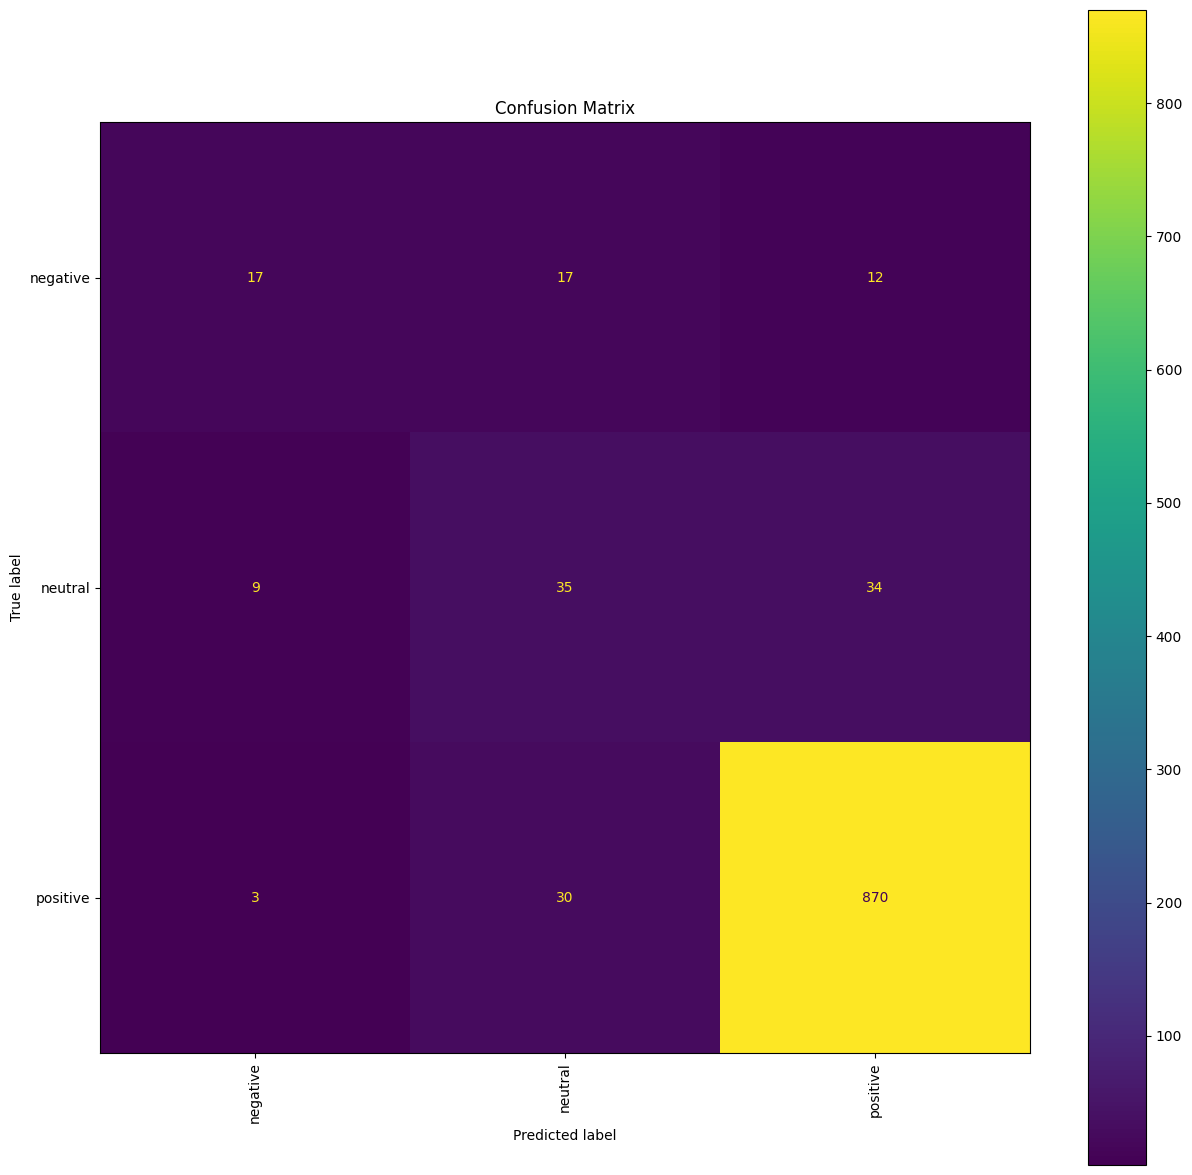

In [23]:
# 混同行列
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# 混同行列の可視化
fig, ax = plt.subplots(figsize=(15, 15))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_name)
display.plot(ax=ax)
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.savefig("confusion_matrix.jpg")
plt.show()

## モデルの保存

In [24]:
# 保存先
model_path = "model_finetuned2/"

# モデルの保存
sc_model.save_pretrained(model_path)
# tokenizerの保存
tokenizer.save_pretrained(model_path)

('model_finetuned2/tokenizer_config.json',
 'model_finetuned2/special_tokens_map.json',
 'model_finetuned2/vocab.txt',
 'model_finetuned2/added_tokens.json')

In [25]:
# torchで保存
torch.save(sc_model.state_dict(), "model_finetuned2.ckpt")

In [26]:
# tensorboardによるlogの可視化
from torch.utils import tensorboard
%load_ext tensorboard
%tensorboard --logdir ./output2/logs

Reusing TensorBoard on port 6007 (pid 6704), started 0:36:45 ago. (Use '!kill 6704' to kill it.)